In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

import networkx as nx
import copy
import random
import getpass
import psycopg2 as ps
import os
import re

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import grangercausalitytests


In [3]:
os.getcwd()

'c:\\Users\\Akshay\\OneDrive\\Desktop\\RA\\Working with NetworkX'

In [80]:
# Connecting to database
df = pd.read_csv(" ")
df['event_date'] = pd.to_datetime(df['event_date'])
## Make sure to remove the empty source or target

## We will basically create two time series dfs where the first one is the network where with only one source, and the second is a network the rest of the sources

df_ts_1 = df[df['country'] == ""] 
df_ts_2 = df[df['country'] != ""]

In [ ]:
df['country'].value_counts()

In [82]:

df_ts_1 = df_ts_1.groupby('event_date').size().dropna()
day_count_rest = df_ts_2.groupby('event_date').size().dropna()


In [ ]:
day_count_rest

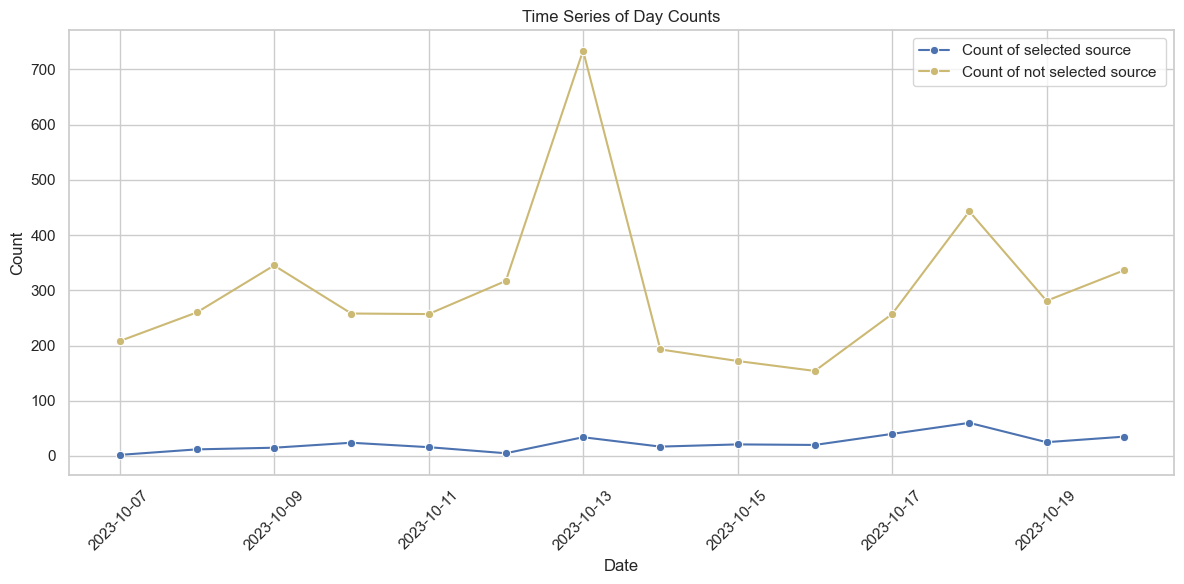

In [84]:
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")  # Optional: Set the style of the plot
sns.lineplot(x=df_ts_1.index, y=df_ts_1.values, marker='o', color='b', label='Count of selected source ')
sns.lineplot(x=day_count_rest.index, y=day_count_rest.values, marker='o', color='y', label='Count of not selected source ')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Time Series of Day Counts')
plt.xticks(rotation=45)  # Optional: Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

In [85]:
scaler = MinMaxScaler()

# Reshape the data to fit the scaler (required for MinMaxScaler)
day_counts1 = df_ts_1.values.reshape(-1, 1)
day_counts2 = day_count_rest.values.reshape(-1, 1)

# Fit and transform the data with MinMaxScaler
normalized_counts1 = scaler.fit_transform(day_counts1)
normalized_counts2 = scaler.fit_transform(day_counts2)


In [ ]:
normalized_ts1 = pd.DataFrame(normalized_counts1, index=df_ts_1.index, columns=['Normalized_Count_source'])
normalized_rest_df = pd.DataFrame(normalized_counts2, index=day_count_rest.index, columns=['Normalized_Count_Rest'])
normalized_ts1.dropna()
normalized_rest_df.dropna()

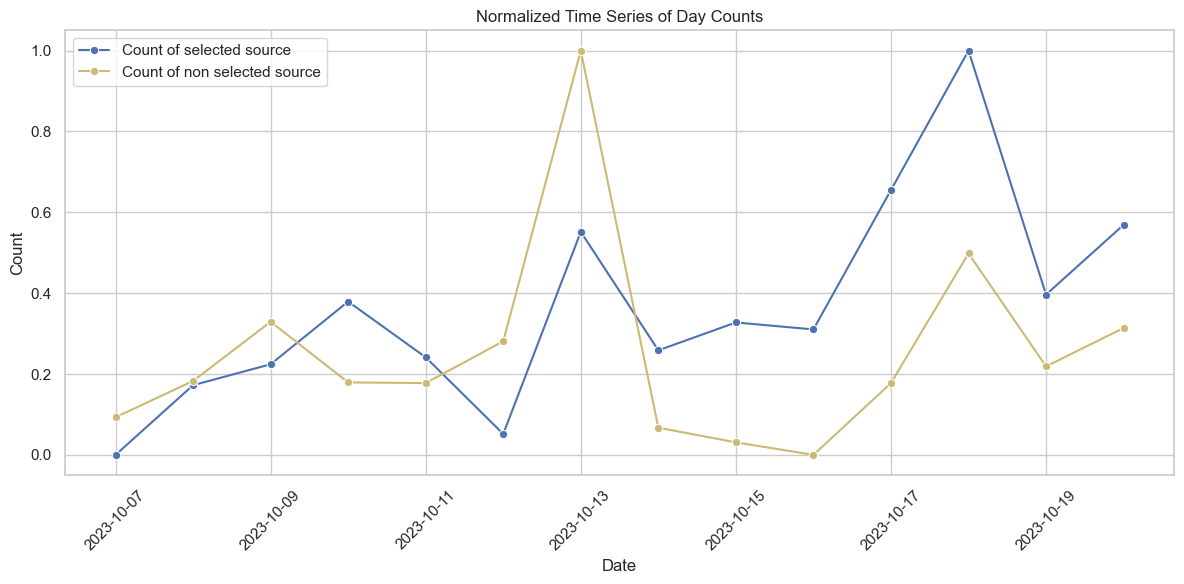

In [87]:
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")  # Optional: Set the style of the plot
sns.lineplot(x=normalized_ts1.index, y=normalized_ts1['Normalized_Count_source'], marker='o', color='b', label='Count of selected source')
sns.lineplot(x=normalized_rest_df.index, y=normalized_rest_df['Normalized_Count_Rest'], marker='o', color='y', label='Count of non selected source')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Normalized Time Series of Day Counts')
plt.xticks(rotation=45)  # Optional: Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

In [88]:
data = pd.concat([ normalized_rest_df['Normalized_Count_Rest'], normalized_ts1['Normalized_Count_source']], axis=1)
data['Normalized_Count_source'] = data['Normalized_Count_source'].fillna(0)
# Perform Granger causality test
max_lag = 3  # Set the maximum lag for the test
results = grangercausalitytests(data, max_lag, verbose=True)

p_values, F_values = [],[]
for lag, result in results.items():
    p_value = result[0]["ssr_ftest"][1]
    f_value =result[0]["ssr_ftest"][0]
    p_values.append(p_value)
    F_values.append(f_value)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4354  , p=0.5243  , df_denom=10, df_num=1
ssr based chi2 test:   chi2=0.5660  , p=0.4519  , df=1
likelihood ratio test: chi2=0.5540  , p=0.4567  , df=1
parameter F test:         F=0.4354  , p=0.5243  , df_denom=10, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9415  , p=0.4344  , df_denom=7, df_num=2
ssr based chi2 test:   chi2=3.2280  , p=0.1991  , df=2
likelihood ratio test: chi2=2.8587  , p=0.2395  , df=2
parameter F test:         F=0.9415  , p=0.4344  , df_denom=7, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2120  , p=0.4132  , df_denom=4, df_num=3
ssr based chi2 test:   chi2=9.9991  , p=0.0186  , df=3
likelihood ratio test: chi2=7.1124  , p=0.0684  , df=3
parameter F test:         F=1.2120  , p=0.4132  , df_denom=4, df_num=3


c:\Users\Akshay\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [71]:
results_df = pd.DataFrame({'Lag (days)': range(1, max_lag + 1), 'P-Value': p_values, "F-Value" : F_values})
results_df.head()

,Lag (days),P-Value,F-Value
0,1,0.847671,0.038862
1,2,0.715657,0.351066
2,3,0.787592,0.357796


In [61]:
print(results_df[results_df['P-Value'] <= 0.05])

   Lag (days)   P-Value   F-Value
0           1  0.038412  5.678905


In [ ]:
df_ts_1.set_index('Day', inplace=True)
df_ts_2.set_index('Day', inplace=True)

In [109]:


# Group by 3-day intervals and count the occurrences
day_count_ts1_3d = df_ts_1.resample('3D').size().dropna() ## Change day length here to your liking
day_count_rest_3_d = df_ts_2.resample('3D').size().dropna()

In [110]:

# Reshape the data to fit the scaler (required for MinMaxScaler)
day_counts1_3d = day_count_ts1_3d.values.reshape(-1, 1)
day_counts2_3d = day_count_rest_3_d.values.reshape(-1, 1)

# Fit and transform the data with MinMaxScaler
normalized_counts1_3d = scaler.fit_transform(day_counts1_3d)
normalized_counts2_3d = scaler.fit_transform(day_counts2_3d)

normalized_source_df_3d = pd.DataFrame(normalized_counts1_3d, index=day_counts1_3d.index, columns=['Normalized_Count_source'])
normalized_rest_df_3d = pd.DataFrame(normalized_counts2_3d, index=day_count_rest_3_d.index, columns=['Normalized_Count_Rest'])


In [ ]:
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")  # Optional: Set the style of the plot
sns.lineplot(x=normalized_source_df_3d.index, y=normalized_source_df_3d['Normalized_Count_source'], marker='o', color='b', label='Count of selected source ')
sns.lineplot(x=normalized_rest_df_3d.index, y=normalized_rest_df_3d['Normalized_Count_Rest'], marker='o', color='y', label='Count of non selected source')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Normalized Time Series of Edge Counts grouped by 5days')
plt.xticks(rotation=45)  # Optional: Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

In [ ]:
data = pd.concat([ normalized_rest_df_3d['Normalized_Count_Rest'], normalized_source_df_3d['Normalized_Count_source']], axis=1)
data['Normalized_Count_source'] = data['Normalized_Count_source'].fillna(0)
data['Normalized_Count_Rest'] = data['Normalized_Count_Rest'].fillna(0)

# Perform Granger causality test
max_lag = 100  # Set the maximum lag for the test
results = grangercausalitytests(data, max_lag, verbose=True)

p_values, F_values = [],[]
for lag, result in results.items():
    p_value = result[0]["ssr_ftest"][1]
    f_value =result[0]["ssr_ftest"][0]
    p_values.append(p_value)
    F_values.append(f_value)

In [ ]:
results_df = pd.DataFrame({'Lag (days)': range(1, max_lag + 1), 'P-Value': p_values, "F-Value" : F_values})
print(results_df[results_df['P-Value'] <= 0.05])